In [93]:
from Scripts import *

### Extract Symbol (i.e Spade/Heart etc...) from bboxed cards

In [279]:
example = cv2.imread('./media/cropped_images/game1/1r4.jpg')

In [280]:
def dense(comps,labels_im):
    # get connected compo with enough pixel count 
    thresh = np.mean(comps[1:,1])
    candidate = np.asarray([comp for comp in comps if comp[1] > thresh])[:,0][1:] # remove background
    
    # compute 
    ret = []
    for obj in candidate:
        
        coords = np.where((labels_im)==obj)
        xmin,xmax = coords[0][0], coords[0][-1]
        ymin,ymax = coords[1][0], coords[1][-1]
    
        # arbitrary value
        if abs(xmax-xmin) < 350 and abs(ymax-ymin) < 350: 
            ret.append(obj)
    return ret

In [281]:
def extract_symbol(img):
    # input gotta be colored and we take green channel
    threshed = (img[:,:,1] < 100) * 255 
    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(
                                                threshed.astype(np.uint8), 4)
    
    # sort by pixel count of a component
    possible = np.array(sorted([(idx,val) for idx,val 
                 in enumerate(stats[:,-1])],
                key=lambda x:x[1],reverse=True))
    
    # get compact and large enough connected components
    r1,r2,r3 = dense(possible, labels_im)[:3]
    
    figure = (labels_im == r1) # represent largest shape and so the number
    sym1 = (labels_im == r2) # represent symbols
    sym2 = (labels_im == r3)
    
    # bboxes
    x1,x2,y1,y2 = get_rectanglecoords(figure)
    x1s,x2s,y1s,y2s = get_rectanglecoords(sym1)
    x1w,x2w,y1w,y2w = get_rectanglecoords(sym2)
    return figure[y1:y2,x1:x2], sym1[y1s:y2s,x1s:x2s], sym2[y1w:y2w,x1w:x2w]

In [282]:
mask_figure, mask_sym1, mask_sym2 = extract_symbol(example)

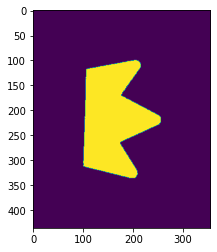

In [283]:
plt.imshow(np.pad(mask_figure,100, 'constant',constant_values= 0))

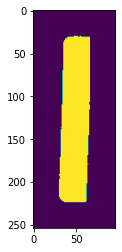

In [284]:
plt.imshow(np.pad(mask_sym1, 30, 'constant',constant_values = 0))

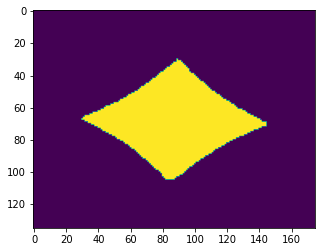

In [285]:
plt.imshow(np.pad(mask_sym2, 30, 'constant',constant_values = 0))

Apply on all cropped out images from extract main

In [270]:
def compare_ratio(img1,img2):
    a,b = img1.shape
    c,d = img2.shape
    return (max(a,b) / min(a,b)) < (max(c,d) / min(c,d))

In [271]:
path = './media/cropped_images/'
target_path = './media/cropped_figures/'
target_path2 = './media/cropped_symb/'

for game in os.listdir(path):
    game_path = path + game 
        
    try: 
        os.makedirs(target_path + game)
    except:
        print('file exist')
    try:
        os.makedirs(target_path2 + game)
    except:
        print('file exist')
    for rd in os.listdir(game_path):
        if 'c' in rd: continue
        img = cv2.imread(game_path + '/' + rd)
        try: mask_fig, mask_sym1, mask_sym2 = extract_symbol(img)
        except: continue
        
        if compare_ratio(mask_sym1,mask_sym2):
            cv2.imwrite(target_path2 + game + '/'+ rd, 
                        255 * np.pad(mask_sym1, 30, 'constant',
                        constant_values = 0).astype(np.uint8))
        else:
            cv2.imwrite(target_path2 + game + '/'+ rd, 
                        255 * np.pad(mask_sym2, 30, 'constant',
                        constant_values = 0).astype(np.uint8))
        
        
        cv2.imwrite(target_path + game + '/'+rd, 255* np.pad(mask_fig,100, 'constant'
                                                        ,constant_values= 0).astype(np.uint8))

file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist
file exist


<b> Separating for symbols, experiments? </b>

In [197]:
d = Dataset(root='./train_games/')
images, label = d.getitem('game1')

In [199]:
label

,round,P1,P2,P3,P4,D,game
0,1,QS,8H,JH,0S,1,game1
1,2,5S,JS,9C,KD,1,game1
2,3,1D,3H,7C,3D,1,game1
3,4,1S,JD,4S,4C,1,game1
4,5,0D,6S,3C,2C,1,game1
5,6,8S,9D,3S,KS,1,game1
6,7,4D,7H,7D,6H,1,game1
7,8,0C,KC,9S,8C,1,game1
8,9,5D,5H,1H,7S,1,game1
9,10,QH,QC,6D,9H,1,game1


In [278]:
%timeit  moments = cv2.moments(figure[y1:y2,x1:x2].astype(np.uint8)) 
%timeit huMoments = cv2.HuMoments(moments)
#huMoments

73.2 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.21 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
